# DAML 06 - sklearn Introduction

Michal Grochmal <michal.grochmal@city.ac.uk>

The `sklearn` module in Python tries to *standardize the way machine learning
techniques are performed*.  Instead of technique specific setup and manual application
of the resulting model, `sklearn` proposes a standard class-based API.
Every ML technique in `sklean` uses the following steps to produce a single model.

1.  Every ML technique (model type) is a class that you can import
2.  You feed the *hyperparameters* to the constructor, a new instance of a model
    is bound to the hyperparameters passed in
3.  You call `.fit()` on the input data, which has a standardized form, see below
4.  For models that predict data you use `.predict()` to appl the model
5.  For models that transform the data you use `.transform()`, some models have
    a `.fit_transform()` which will fit and transform the same data

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

## Input and Output

Injecting data and reading the outputs of a model can often be troublesome,
figuring out in which format a model what its parameters is no easy task.
Developers of `sklearn` tried to sort the misery of different libraries
requiring parameters in different formats, and created a standard way in which
all `sklearn` models receive the input.

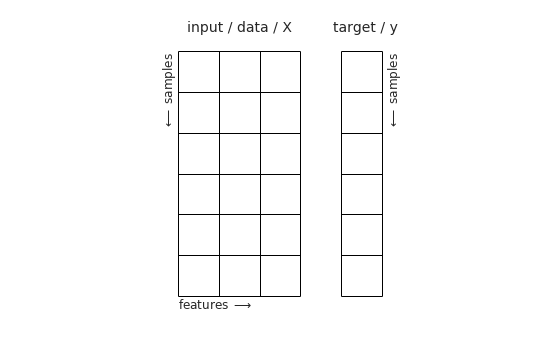

In [2]:
# ignore this code, it is just to draw the figure below
fig, ax = plt.subplots(figsize=(9, 6))
ax.axis('off')
ax.axis('equal')
ax.vlines(range(4), ymin=0, ymax=6, lw=1)
ax.hlines(range(7), xmin=0, xmax=3, lw=1)
ax.vlines(range(4, 6), ymin=0, ymax=6, lw=1)
ax.hlines(range(7), xmin=4, xmax=5, lw=1)
ax.text(1.5, 6.5, "input / data / X", size=14, ha='center')
ax.text(4.6, 6.5, "target / y", size=14, ha='center')
ax.text(0, -0.3, r'features $\longrightarrow$')
samples = r'$\longleftarrow$ samples'
ax.text(0, 6, samples, rotation=90, va='top', ha='right')
ax.text(5.1, 6, samples, rotation=90, va='top', ha='left')
ax.set_ylim(-1, 7);

At first one may argue that this will only work for two dimensions,
but if you remember the ideas of *group by* and *pivot* we can see that
we can represent several dimensions in a two dimensional table.

## Hyperparameters

What the hell are those *hyperparameters*?
These are simply free parameters that interfere in the inner workings of the model.
By *free* we mean that the model works independently of what we set these parameters to.
Yet, the values we give influence how well the model performs against a specific dataset.

Therefore yes, the entire practice of machine learning is about finding the right model
and the right model hyperparameters.  This could not be harder though, the combination of
several free parameters goes into millions of thousands of millions for some models.

As a simple example let's implement k nearest neighbours, a model that has a single
hyperparameter.

In [3]:
class MyKNN(object):
    def __init__(self, k=1):
        self.k_ = k

    def fit(self, data, y):
        self.data = data
        self.y = y

    def predict(self, new_data):
        sq_dist_dim = (new_data[:, np.newaxis, :] - self.data[np.newaxis, :, :])**2
        sq_dist = sq_dist_dim.sum(axis=-1)
        self.nearest_ = np.argpartition(sq_dist, self.k_, axis=1)
        new_y = self.y[self.nearest_[:, :self.k_]]
        new_y = np.apply_along_axis(lambda x: np.bincount(x, minlength=2), axis=1, arr=new_y)
        return new_y.argmax(axis=1)  # not really correct for even k, hides ties

(array([0, 1, 1, 0, 0, 1]), array([0, 1, 0, 0, 1, 1]))

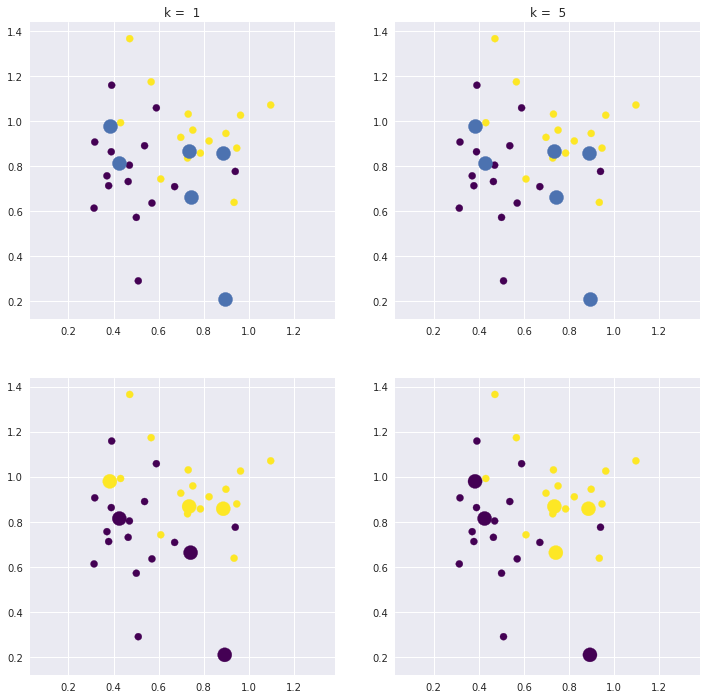

In [4]:
random_state = 27
rng = np.random.RandomState(random_state)
data, y = make_blobs(30, 2, centers=2, cluster_std=0.2, center_box=(0, 1), random_state=random_state)
new_data = rng.rand(6, 2)
knn_left = MyKNN(k=1)
knn_left.fit(data, y)
new_yl = knn_left.predict(new_data)
knn_right = MyKNN(k=5)
knn_right.fit(data, y)
new_yr = knn_right.predict(new_data)
fig, ax = plt.subplots(2, 2, figsize=(12, 12))
ax[0, 0].set_title('k =  1')
ax[0, 0].scatter(data[:, 0], data[:, 1], s=50, c=y, cmap='viridis')
ax[0, 0].scatter(new_data[:, 0], new_data[:, 1], s=200)
ax[1, 0].scatter(data[:, 0], data[:, 1], s=50, c=y, cmap='viridis')
ax[1, 0].scatter(new_data[:, 0], new_data[:, 1], s=200, c=new_yl, cmap='viridis')
ax[0, 1].set_title('k =  5')
ax[0, 1].scatter(data[:, 0], data[:, 1], s=50, c=y, cmap='viridis')
ax[0, 1].scatter(new_data[:, 0], new_data[:, 1], s=200)
ax[1, 1].scatter(data[:, 0], data[:, 1], s=50, c=y, cmap='viridis')
ax[1, 1].scatter(new_data[:, 0], new_data[:, 1], s=200, c=new_yr, cmap='viridis')
for axi in ax.flat:
    axi.axis('equal')
new_yl, new_yr

We need a way to tell what is a good value for $k$.
Since we have several points for which we know the label already we can use
them to check whether we get the right label.  This should be easy.

How **not** to do it:

In [5]:
knn = MyKNN(k=1)
knn.fit(data, y)
new_y = knn.predict(data)
error = (y - new_y)**2
error.mean()

0.0

A perfect model!  Which means $k = 5$ must be wrong, right?

In [6]:
knn = MyKNN(k=5)
knn.fit(data, y)
new_y = knn.predict(data)
error = (y - new_y)**2
error.mean()

0.20000000000000001

There is something fishy about this.  Can you tell?

Let's get some help from `sklearn`

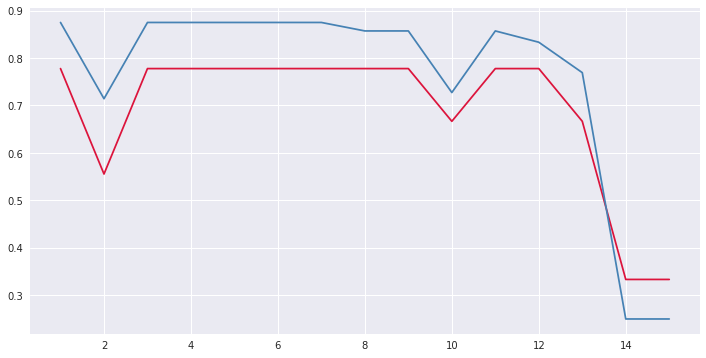

In [7]:
data1, data2, y1, y2 = train_test_split(data, y, random_state=random_state, train_size=0.7, test_size=0.3)
accuracy = []
f1_scores = []
k_vals = list(range(1, 16))
for k in k_vals:
    knn = MyKNN(k=k)
    knn.fit(data1, y1)
    new_y = knn.predict(data2)
    accuracy.append(accuracy_score(y2, new_y))
    f1_scores.append(f1_score(y2, new_y))

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(k_vals, accuracy, color='crimson')
ax.plot(k_vals, f1_scores, color='steelblue');

There are [many, many ways to calculate the "correctness" of what a model did spit out][metrics].
And several of these are better for specific problems than others.  As a rule of thumb,
a "good enough" first try measure is the F1 score, which performs well enough for most problems.
It is defined in terms of *precision* and *recall*:

#### precision

$$P = \frac{true\:positives}{true\:positives + false\:positives}$$

#### recall

$$R = \frac{true\:positives}{true\:positives + false\:negatives}$$

#### F1 score

$$F_1 = \frac{1}{\frac{1}{P} + \frac{1}{R}}=2 \frac{P \cdot R}{P + R}$$

In this model we have only a single free parameter,
and it is integer valued which makes it easy to select by hand.
Some models have dozens of real valued parameters making the search
for an optimal parameter much harder.
We will see that when we look at these models.

[metrics]: http://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics

## References

-   [Evaluation of retrieved sets/classes - IR intro][1]

[1]: https://nlp.stanford.edu/IR-book/html/htmledition/evaluation-of-unranked-retrieval-sets-1.html